In [11]:
import numpy as np 
import pandas as pd
import numpy as np
from sklearn.svm import SVC, SVR
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              AdaBoostClassifier)
from sklearn.tree import DecisionTreeClassifier
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

import os
print(os.listdir("../input"))


['faults.csv']


In [2]:
dataset=pd.read_csv("../input/faults.csv")
dataset[0:6]

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,1687,1,0,80,0.0498,0.2415,0.1818,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,1687,1,0,80,0.7647,0.3793,0.2069,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,1623,1,0,100,0.9710,0.3426,0.3333,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,1353,0,1,290,0.7287,0.4413,0.1556,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,1353,0,1,185,0.0695,0.4486,0.0662,0.0126,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0
5,430,441,100250,100337,630,20,87,62357,64,127,1387,0,1,40,0.6200,0.3417,0.1264,0.0079,0.5500,1.0000,1.0,2.7993,1.0414,1.9395,0.8736,-0.2267,0.9874,1,0,0,0,0,0,0


In [3]:
headers = list(dataset.columns.values)
headers_input = headers[:-7]
headers_output = headers[-7:]
print('features for input X:', headers_input)
print('classes for output Y:', headers_output)

features for input X: ['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer', 'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas']
classes for output Y: ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']


In [4]:
input_x = dataset[headers_input]
output_y = dataset[headers_output]

Which features are not important

In [5]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
np_scaled = min_max_scaler.fit_transform(input_x)
headers_27 = list(input_x.columns.values)
input_x_27 = pd.DataFrame(np_scaled)
input_x_27.columns = headers_27
input_x_27[0:3]

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,0.024633,0.026916,0.020352,0.020354,0.001736,0.001436,0.002369,0.002068,0.374384,0.328704,0.811287,1.0,0.0,0.153846,0.050040,0.255853,0.174952,0.003660,0.462865,1.000000,1.0,0.435312,0.217122,0.385916,0.912493,0.431200,0.525766
1,0.378299,0.378584,0.195006,0.195007,0.000694,0.000766,0.001598,0.000962,0.413793,0.398148,0.811287,1.0,0.0,0.153846,0.768388,0.401843,0.200262,0.002402,0.594156,0.965006,1.0,0.354804,0.172082,0.343391,0.899834,0.501706,0.203632
2,0.486217,0.486249,0.119190,0.119190,0.000452,0.000574,0.000992,0.000666,0.487685,0.407407,0.698413,1.0,0.0,0.230769,0.975683,0.362962,0.327720,0.002516,0.746347,0.944725,1.0,0.317509,0.172082,0.294761,0.836082,0.533882,0.108967


Value of Y is number between [0;6], which represent each class:

In [8]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
targets=(output_y.iloc[:,:]==1).idxmax(1)
print(targets.value_counts())
Y=le.fit_transform(targets)
print(len(Y))

Other_Faults    673
Bumps           402
K_Scatch        391
Z_Scratch       190
Pastry          158
Stains           72
Dirtiness        55
dtype: int64
1941


In [9]:
X_train_27, X_test_27, y_train_27, y_test_27 = train_test_split(input_x_27, Y, test_size=0.3)

No handles with labels found to put in legend.


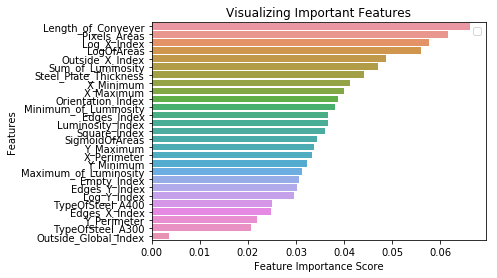

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train_27,y_train_27)
headers_norm = list(X_train_27.columns.values)
feature_imp = pd.Series(clf.feature_importances_,index=headers_norm).sort_values(ascending=False)
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

The most important features accoding to Random Forest are: Length_of_Conveyer, LogOfAreas, Pixels_Areas, Steel_Plate_Thickness, Sum_of_Luminosity, Log_X_Index, X_Maximum. 

We will drop values which are not important based on dimensionality reduction: high Correlation filter

In [14]:
# Create correlation matrix
corr_matrix = input_x.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(to_drop)

['X_Maximum', 'Y_Maximum', 'X_Perimeter', 'Sum_of_Luminosity', 'TypeOfSteel_A400']


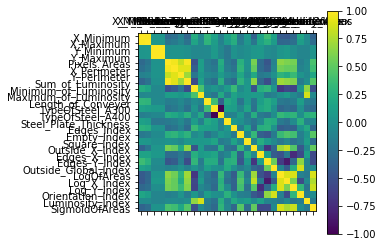

In [15]:
plt.matshow(input_x.corr())
plt.xticks(range(len(input_x.columns)), input_x.columns)
plt.yticks(range(len(input_x.columns)), input_x.columns)
plt.colorbar()
plt.show()

Drop features that have correlation with other features as they are not important according to Random Forest feature selection.

In [16]:
input_x = input_x.drop(input_x[to_drop], axis=1)
input_x[0:6]

,X_Minimum,Y_Minimum,Pixels_Areas,Y_Perimeter,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,42,270900,267,44,76,108,1687,1,80,0.0498,0.2415,0.1818,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822
1,645,2538079,108,30,84,123,1687,1,80,0.7647,0.3793,0.2069,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984
2,829,1553913,71,19,99,125,1623,1,100,0.9710,0.3426,0.3333,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150
3,853,369370,176,45,99,126,1353,0,290,0.7287,0.4413,0.1556,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212
4,1289,498078,2409,260,37,126,1353,0,185,0.0695,0.4486,0.0662,0.0126,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000
5,430,100250,630,87,64,127,1387,0,40,0.6200,0.3417,0.1264,0.0079,0.5500,1.0000,1.0,2.7993,1.0414,1.9395,0.8736,-0.2267,0.9874


We will drop values further based on dimensionality reduction: low variance filter.
We will check variations of each columns, and drop some features wich have less variation.

In [17]:
input_x.var()

X_Minimum                2.711188e+05
Y_Minimum                3.149129e+12
Pixels_Areas             2.671297e+07
Y_Perimeter              1.818876e+05
Minimum_of_Luminosity    1.032612e+03
Maximum_of_Luminosity    3.493532e+02
Length_of_Conveyer       2.090275e+04
TypeOfSteel_A300         2.401855e-01
Steel_Plate_Thickness    3.034471e+03
Edges_Index              8.982713e-02
Empty_Index              1.884072e-02
Square_Index             7.347265e-02
Outside_X_Index          3.476419e-03
Edges_X_Index            5.918366e-02
Edges_Y_Index            5.488413e-02
Outside_Global_Index     2.326634e-01
LogOfAreas               6.224103e-01
Log_X_Index              2.319497e-01
Log_Y_Index              2.064295e-01
Orientation_Index        2.508688e-01
Luminosity_Index         2.213157e-02
SigmoidOfAreas           1.152275e-01
dtype: float64

We find all the columns, which values varies less then 10%:

In [18]:
numeric = input_x
var = numeric.var()
numeric = numeric.columns
variable = [ ]
for i in range(0,len(var)):
    if var[i]>=10:   #setting the threshold as 10%
        variable.append(numeric[i+1])

In [19]:
variable

['Y_Minimum',
 'Pixels_Areas',
 'Y_Perimeter',
 'Minimum_of_Luminosity',
 'Maximum_of_Luminosity',
 'Length_of_Conveyer',
 'TypeOfSteel_A300',
 'Edges_Index']

Low variance filter shows features which are important according to Random Forest feature selection, so we will not drop  them. 

In [20]:
# important features according to Random Forest
print(feature_imp)

Length_of_Conveyer       0.066272
Pixels_Areas             0.061566
Log_X_Index              0.057570
LogOfAreas               0.056056
Outside_X_Index          0.048663
Sum_of_Luminosity        0.047155
Steel_Plate_Thickness    0.044254
X_Minimum                0.041224
X_Maximum                0.040016
Orientation_Index        0.038723
Minimum_of_Luminosity    0.038047
Edges_Index              0.036619
Luminosity_Index         0.036580
Square_Index             0.036137
SigmoidOfAreas           0.034465
Y_Maximum                0.033668
X_Perimeter              0.033279
Y_Minimum                0.032214
Maximum_of_Luminosity    0.031179
Empty_Index              0.030642
Edges_Y_Index            0.030124
Log_Y_Index              0.029530
TypeOfSteel_A400         0.024934
Edges_X_Index            0.024869
Y_Perimeter              0.021830
TypeOfSteel_A300         0.020706
Outside_Global_Index     0.003681
dtype: float64


In [21]:
print(len(input_x.iloc[0,:]))

22


We will compare distribution of each classes.  

In [24]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
np_scaled = min_max_scaler.fit_transform(input_x)
input_x_norm = pd.DataFrame(np_scaled)
headers_22= list(input_x.columns.values)
input_x_norm.columns = headers_22
input_x_norm[0:6]

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,X_Minimum,Y_Minimum,Pixels_Areas,Y_Perimeter,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,0.024633,0.020352,0.001736,0.002369,0.374384,0.328704,0.811287,1.0,0.153846,0.050040,0.255853,0.174952,0.003660,0.462865,1.000000,1.0,0.435312,0.217122,0.385916,0.912493,0.431200,0.525766
1,0.378299,0.195006,0.000694,0.001598,0.413793,0.398148,0.811287,1.0,0.153846,0.768388,0.401843,0.200262,0.002402,0.594156,0.965006,1.0,0.354804,0.172082,0.343391,0.899834,0.501706,0.203632
2,0.486217,0.119190,0.000452,0.000992,0.487685,0.407407,0.698413,1.0,0.230769,0.975683,0.362962,0.327720,0.002516,0.746347,0.944725,1.0,0.317509,0.172082,0.294761,0.836082,0.533882,0.108967
3,0.500293,0.027938,0.001140,0.002424,0.487685,0.412037,0.222222,0.0,0.961538,0.732215,0.467528,0.148533,0.004231,0.531757,1.000000,1.0,0.398243,0.196206,0.388194,0.925707,0.513163,0.456527
4,0.756012,0.037853,0.015768,0.014269,0.182266,0.412037,0.222222,0.0,0.557692,0.069835,0.475262,0.058385,0.012694,0.272829,0.987915,1.0,0.630962,0.335184,0.565877,0.970797,0.487325,1.000000
5,0.252199,0.007206,0.004114,0.004738,0.315271,0.416667,0.282187,0.0,0.000000,0.622990,0.362009,0.119088,0.007319,0.543425,1.000000,1.0,0.511664,0.266994,0.455421,0.940435,0.470567,0.985698


In [25]:
# Import train_test_split function
X_train, X_test, y_train, y_test = train_test_split(input_x_norm, Y, test_size=0.3)

Decision Trees, Random Forest Classifier, ExtraTrees, AdaBoost:

In [26]:
# Parameters
n_classes = 7
n_estimators = 100
RANDOM_SEED = 13  # fix the seed on each iteration

names = ['DecisionTreeClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier', 'AdaBoostClassifier']
models = [DecisionTreeClassifier(max_depth=None),
          RandomForestClassifier(n_estimators=n_estimators),
          ExtraTreesClassifier(n_estimators=n_estimators),
          AdaBoostClassifier(DecisionTreeClassifier(max_depth=None),
                             n_estimators=n_estimators)]
for counter, model in enumerate(models):
    # Train
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy " + names[counter] + ":",metrics.accuracy_score(y_test, y_pred))

Accuracy DecisionTreeClassifier: 0.7358490566037735
Accuracy RandomForestClassifier: 0.7684391080617495
Accuracy ExtraTreesClassifier: 0.7855917667238422
Accuracy AdaBoostClassifier: 0.7341337907375644


Extra Trees Classifier is the most accurate algorithm

In [ ]:
input_x_NN = dataset[headers_input]
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
np_scaled = min_max_scaler.fit_transform(input_x_NN)
df_normalized = pd.DataFrame(np_scaled)
df_normalized.columns = headers_input
df_normalized[0:6]

We create one-hot encoding for the output y:

In [ ]:
#One Hot Encode our Y:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
Y_one_hot = encoder.fit_transform(Y)
print(Y_one_hot)

We will create more samples for the class, which has less amount of samples:

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
ros = RandomOverSampler(random_state=0)
X = input_x_norm #df_normalized
ros.fit(X, Y)
X_resampled, y_resampled = ros.fit_sample(X, Y)
print('Amount of elements before:', len(X))
print('Amount of elements after:', len(X_resampled))

We increased the amount of classes, so we have 4711 elements instead of 1941, each class has 673 elements 

In [ ]:
unique, counts = np.unique(y_resampled, return_counts=True)
dict(zip(unique, counts))

Split data to train and test:

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,
                                                 Y_one_hot,
                                                 test_size = 0.3,#%70 train, 30% test
                                                 random_state = 3)

Multilayer perceptron: 

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

model = Sequential()

model.add(Dense(64, activation='relu', input_dim=22))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

model.fit(X_train, y_train,
          epochs=2000,
          batch_size=128)

In [ ]:
score = model.evaluate(X_test, y_test, batch_size=128)
print(score)
print(model.metrics_names)

The accuracy on test set:

In [ ]:
Y_predicted = model.predict(X_test, batch_size=32, verbose=0)
percent = 0
for i in range(0, len(Y_predicted)):
    class_id_predicted = np.argmax(Y_predicted[i])
    class_id_real = np.argmax(y_test[i])
    if class_id_predicted == class_id_real: 
        percent += 1
print('val accuracy: ', percent/len(Y_predicted))